In [1]:
import os, numpy as np

DATA_DIR = "data/deepwriting"
SPLITS = {
    "train":      "deepwriting_training.npz",
    "val":         "deepwriting_validation.npz"
}

for split, fn in SPLITS.items():
    inp = os.path.join(DATA_DIR, fn)
    outdir = os.path.join(DATA_DIR, split)
    os.makedirs(outdir, exist_ok=True)
    print(f"Splitting {inp} → {outdir}/")
    arr = np.load(inp, allow_pickle=True)
    strokes = arr['strokes']
    texts   = arr['texts']
    for i, (s, t) in enumerate(zip(strokes, texts)):
        s = s.astype(np.float32)
        np.savez(os.path.join(outdir, f"{i:06d}.npz"),
                 strokes=s, chars=t)
    arr.close()


Splitting data/deepwriting\deepwriting_training.npz → data/deepwriting\train/
Splitting data/deepwriting\deepwriting_validation.npz → data/deepwriting\val/


In [2]:
import os, numpy as np


stats = np.load(os.path.join(DATA_DIR, "deepwriting_training.npz"), allow_pickle=True)
global_mean = stats['mean'].astype(np.float32)  # shape (3,)
global_std  = stats['std'].astype(np.float32)   # shape (3,)
stats.close()
print("Global mean:", global_mean, "Global std:", global_std)

Global mean: [1.0562458e-03 2.8255243e-05 4.2473756e-02] Global std: [0.00564527 0.00785551 0.19761197]


In [3]:
import torch
from torch.utils.data import Dataset, DataLoader

class SketchRNNDataset(Dataset):
    def __init__(self, folder, mean, std, max_len=250):
        self.files = sorted(os.listdir(folder))
        self.mean, self.std = mean, std
        self.max_len = max_len

    def __len__(self): return len(self.files)
    def __getitem__(self, i):
        data = np.load(os.path.join(folder, self.files[i]), allow_pickle=True)
        strokes = data['strokes'][:self.max_len].astype(np.float32)
        # normalize
        strokes = (strokes - self.mean) / self.std
        # pad to max_len
        pad = self.max_len - strokes.shape[0]
        if pad>0:
            strokes = np.pad(strokes, ((0,pad),(0,0)), 'constant')
        return torch.from_numpy(strokes)  # (max_len, 3)

def collate_fn(batch):
    # batch: list of (T,3) already fixed at max_len
    return torch.stack(batch,0)  # (B,max_len,3)

# example loader
train_ds = SketchRNNDataset(os.path.join(DATA_DIR,'train'), global_mean, global_std)
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True, collate_fn=collate_fn, num_workers=4)

In [4]:
# %% [markdown]
# ## 4. SketchRNN Model

# %%
import torch.nn as nn

class SketchRNN(nn.Module):
    def __init__(self, input_dim=3, hid_dim=256, z_dim=128, n_layers=1, n_mixes=20):
        super().__init__()
        # -- Encoder P(h|x)
        self.enc_rnn = nn.LSTM(input_dim, hid_dim, n_layers, batch_first=True, bidirectional=True)
        self.fc_mu  = nn.Linear(2*hid_dim, z_dim)
        self.fc_logvar = nn.Linear(2*hid_dim, z_dim)

        # -- Decoder p(x|z)
        self.z2h = nn.Linear(z_dim, hid_dim)
        self.dec_rnn = nn.LSTM(input_dim + hid_dim, hid_dim, n_layers, batch_first=True)
        self.fc_out = nn.Linear(hid_dim, n_mixes*6 + 3)  
        # (6 params per Gaussian + pen_up, pen_down, pen_end)

        self.hid_dim, self.z_dim, self.n_mixes = hid_dim, z_dim, n_mixes

    def encode(self, x):
        # x: (B, T, 3)
        _, (h,_) = self.enc_rnn(x)  # h: (2*n_layers, B, hid_dim)
        h = torch.cat([h[-2], h[-1]], dim=1)  # (B, 2*hid_dim)
        mu     = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z, x):
        # z: (B, z_dim), x: teacher-forced strokes (B, T, 3)
        h0 = torch.tanh(self.z2h(z)).unsqueeze(0)  # initial hidden
        c0 = torch.zeros_like(h0)
        B,T,_ = x.size()
        zrep = z.unsqueeze(1).expand(-1,T,-1)
        inp = torch.cat([x, zrep], dim=2)  # (B, T, 3+z_dim)
        out, _ = self.dec_rnn(inp, (h0,c0))
        params = self.fc_out(out)  # (B, T, n_mixes*6+3)
        return params

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        params = self.decode(z, x)
        return params, mu, logvar


In [5]:
# %% [markdown]
# ## 5. Losses: Reconstruction + KL

# %%
import torch.nn.functional as F

def sketchrnn_loss(params, target, mu, logvar, n_mixes, kl_weight=0.5):
    """
    params: (B,T,6*M+3)
      - first 6*M for MDN
      - last 3 are pen_up/down/end logits (use CE)
    target: (B,T,3) with (dx,dy,one-hot pen state)
    """
    B,T,_ = params.size()
    # split params
    mdn_params = params[:,:,:6*n_mixes]    # MDN part
    pen_logits = params[:,:,6*n_mixes:]   # (B,T,3)
    # MDN reconstruction over dx,dy
    recon = mdn_loss(mdn_params, target[:,:,:3], n_mixes)
    # pen state CE
    pen_true = F.one_hot(target[:,:,2].long(), num_classes=3).float()
    pen_loss = F.cross_entropy(pen_logits.view(-1,3), pen_true.view(-1,3), reduction='mean')
    # KL divergence
    kl = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return recon + pen_loss + kl_weight*kl


In [6]:
# %% [markdown]
# ## Setup Device

# %%
import torch

# choose GPU if available, otherwise CPU
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)


Using device: cuda


FINAL

In [1]:
# Full training script with visible per‐epoch & per‐batch progress (no multiprocessing)

import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from tqdm import tqdm
import math

# 0. Hyperparameters & device
DEVICE     = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 32
EPOCHS     = 10
LR         = 1e-3
N_MIX      = 20
MAX_SEQ    = 500

In [2]:
# 1. Load global normalization stats
stats = np.load("data/deepwriting/deepwriting_training.npz", allow_pickle=True)
GLOBAL_MEAN = stats['mean'].astype(np.float32)
GLOBAL_STD  = stats['std'].astype(np.float32)
stats.close()

# 2. Vocabulary
vocab    = ['<pad>','<s>','</s>','<unk>'] + [chr(i) for i in range(32,127)]
char2idx = {c:i for i,c in enumerate(vocab)}

# 3. Dataset & collate
class DeepWritingDataset(Dataset):
    def __init__(self, folder, char2idx, max_seq=MAX_SEQ):
        self.files = sorted(os.listdir(folder))
        self.folder = folder
        self.c2i = char2idx
        self.max_seq = max_seq

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        path = os.path.join(self.folder, self.files[idx])
        npz  = np.load(path, allow_pickle=True)
        # 1. load strokes and text
        s    = npz['strokes'][:self.max_seq].astype(np.float32)
        txt  = npz['chars'].item()
        npz.close()

        # 2. normalize
        s = (s - GLOBAL_MEAN) / GLOBAL_STD

        # 3. tokenize
        toks = ['<s>'] + list(txt) + ['</s>']
        seq  = [self.c2i.get(t, self.c2i['<unk>']) for t in toks]

        return torch.from_numpy(s), torch.tensor(seq, dtype=torch.long)


def collate_fn(batch):
    strokes, texts = zip(*batch)
    B = len(batch)
    lens_s = [s.shape[0] for s in strokes]
    lens_t = [t.numel()   for t in texts]
    T_max = max(lens_s); L_max = max(lens_t)

    S = torch.zeros(B, T_max, 3)
    for i, s in enumerate(strokes): S[i,:s.shape[0]] = s
    T = torch.full((B, L_max), 0, dtype=torch.long)
    for i, t in enumerate(texts):   T[i,:t.numel()]  = t

    return {'strokes': S,
            'seq_lens': torch.tensor(lens_s),
            'texts':    T,
            'text_lens':torch.tensor(lens_t)}

In [3]:
# 4. Model components
class TextEncoder(nn.Module):
    def __init__(self, vocab_size, emb_dim=128, hid_dim=256, n_layers=1):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.lstm  = nn.LSTM(emb_dim, hid_dim, n_layers,
                             bidirectional=True, batch_first=True)
    def forward(self, txt, lengths):
        e = self.embed(txt)
        p = pack_padded_sequence(e, lengths.cpu(), batch_first=True, enforce_sorted=False)
        out,_ = self.lstm(p)
        o,_   = pad_packed_sequence(out, batch_first=True)
        H = o.size(2)//2
        return o[:,:,:H] + o[:,:,H:]

class Attention(nn.Module):
    def __init__(self, dec_dim, enc_dim):
        super().__init__()
        self.lin = nn.Linear(dec_dim + enc_dim, enc_dim)
        self.v   = nn.Linear(enc_dim, 1, bias=False)
    def forward(self, h_t, enc_out):
        B,L,_ = enc_out.size()
        h_exp = h_t.unsqueeze(1).expand(-1,L,-1)
        e = torch.tanh(self.lin(torch.cat([h_exp, enc_out], dim=2)))
        a = torch.softmax(self.v(e).squeeze(2), dim=1)
        ctx = torch.bmm(a.unsqueeze(1), enc_out).squeeze(1)
        return ctx, a

class HandwritingDecoder(nn.Module):
    def __init__(self, enc_dim=256, dec_dim=512, n_layers=2, n_mix=N_MIX):
        super().__init__()
        self.lstm = nn.LSTM(3 + enc_dim, dec_dim, n_layers, batch_first=True)
        self.attn = Attention(dec_dim, enc_dim)
        self.fc   = nn.Linear(dec_dim, n_mix*6 + 1)
        self.n_mix = n_mix
    def forward(self, strokes, enc_out):
        B,T,_= strokes.size()
        h=c=None; outs=[]
        for t in range(T-1):
            if t==0:
                layers,_,hS = self.lstm.num_layers, B, self.lstm.hidden_size
                h = torch.zeros(layers,B,hS, device=strokes.device)
                c = torch.zeros_like(h)
            prev = strokes[:,t]
            ctx,_ = self.attn(h[-1], enc_out)
            x = torch.cat([prev, ctx], dim=1).unsqueeze(1)
            out,(h,c) = self.lstm(x,(h,c))
            outs.append(self.fc(out.squeeze(1)))
        return torch.stack(outs, dim=1)

class HandwritingModel(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.enc = TextEncoder(vocab_size)
        self.dec = HandwritingDecoder()
    def forward(self, strokes, texts, text_lens):
        enc = self.enc(texts, text_lens)
        return self.dec(strokes, enc)


In [4]:
# 5. MDN loss
def mdn_loss(params, target, n_mix):
    B,T,D = params.size()
    p = params.view(B,T, n_mix*6+1)
    log_pi = F.log_softmax(p[...,:n_mix], dim=-1)
    idx = n_mix
    mu_x = p[..., idx:idx+n_mix]; idx+=n_mix
    mu_y = p[..., idx:idx+n_mix]; idx+=n_mix
    log_sx = p[..., idx:idx+n_mix]; idx+=n_mix
    log_sy = p[..., idx:idx+n_mix]; idx+=n_mix
    rho    = torch.tanh(p[..., idx:idx+n_mix]); idx+=n_mix
    pen_logits = p[..., -1]

    x = target[...,0].unsqueeze(-1); y = target[...,1].unsqueeze(-1)
    pen = target[...,2]
    sx = torch.exp(log_sx); sy = torch.exp(log_sy)
    nx = (x-mu_x)/sx; ny = (y-mu_y)/sy
    z  = nx**2 + ny**2 - 2*rho*nx*ny
    denom = 2*(1-rho**2)
    log_coeff = - log_sx - log_sy - 0.5*torch.log(2*math.pi*(1-rho**2))
    log_gauss = -z/denom + log_coeff

    log_mix = log_pi + log_gauss
    loss_pt = -torch.logsumexp(log_mix,dim=-1).mean()
    loss_pen= F.binary_cross_entropy_with_logits(pen_logits, pen, reduction='mean')
    return loss_pt + loss_pen


In [5]:

# 6. Instantiate datasets, dataloaders, model, optimizer
train_ds = DeepWritingDataset("data/deepwriting/train", char2idx)
val_ds   = DeepWritingDataset("data/deepwriting/val",   char2idx)
train_dl = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_fn,
    pin_memory=True,
    num_workers=0   # ← set to 0 in notebooks!
)
val_dl = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_fn,
    pin_memory=True,
    num_workers=0
)

model = HandwritingModel(len(vocab)).to(DEVICE)
opt   = torch.optim.Adam(model.parameters(), lr=LR)
sched = torch.optim.lr_scheduler.StepLR(opt, step_size=5, gamma=0.5)


In [6]:
print(f"Train loader length: {len(train_dl)}")
for i, batch in enumerate(train_dl):
    print(f" Batch {i}: ", {k: v.shape for k,v in batch.items()})
    if i >= 2: break

Train loader length: 1081
 Batch 0:  {'strokes': torch.Size([32, 334, 3]), 'seq_lens': torch.Size([32]), 'texts': torch.Size([32, 49]), 'text_lens': torch.Size([32])}
 Batch 1:  {'strokes': torch.Size([32, 341, 3]), 'seq_lens': torch.Size([32]), 'texts': torch.Size([32, 53]), 'text_lens': torch.Size([32])}
 Batch 2:  {'strokes': torch.Size([32, 343, 3]), 'seq_lens': torch.Size([32]), 'texts': torch.Size([32, 47]), 'text_lens': torch.Size([32])}


In [9]:
# 7. Training Loop with tqdm progress bars

best_val = float('inf')
for ep in range(1, EPOCHS+1):
    model.train()
    total_train = 0.0
    print(f"\nEpoch {ep}/{EPOCHS}")

    for batch in tqdm(train_dl, total=len(train_dl), desc="Training"):
        S, T, tL = batch['strokes'].to(DEVICE), batch['texts'].to(DEVICE), batch['text_lens'].to(DEVICE)
        opt.zero_grad()
        out  = model(S, T, tL)
        loss = mdn_loss(out, S[:,1:], model.dec.n_mix)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        opt.step()
        total_train += loss.item()

    sched.step()
    avg_train = total_train / len(train_dl)
    print(f" → Train loss: {avg_train:.4f}")

    model.eval()
    total_val = 0.0
    with torch.no_grad():
        for batch in tqdm(val_dl, total=len(val_dl), desc="Validating"):
            S, T, tL = batch['strokes'].to(DEVICE), batch['texts'].to(DEVICE), batch['text_lens'].to(DEVICE)
            total_val += mdn_loss(model(S, T, tL), S[:,1:], model.dec.n_mix).item()

    avg_val = total_val / len(val_dl)
    print(f" → Val   loss: {avg_val:.4f}")

    if avg_val < best_val:
        best_val = avg_val
        torch.save(model.state_dict(), os.path.join('models/', "best.pth"))
        print(f" ★ Saved best model (val={avg_val:.4f})")



Epoch 1/10


Training: 100%|██████████| 1081/1081 [16:35<00:00,  1.09it/s]


 → Train loss: -33.7908


Validating: 100%|██████████| 23/23 [00:05<00:00,  4.37it/s]


 → Val   loss: -41.5748
 ★ Saved best model (val=-41.5748)

Epoch 2/10


Training: 100%|██████████| 1081/1081 [16:25<00:00,  1.10it/s]


 → Train loss: -57.7069


Validating: 100%|██████████| 23/23 [00:05<00:00,  4.34it/s]


 → Val   loss: -71.1862
 ★ Saved best model (val=-71.1862)

Epoch 3/10


Training: 100%|██████████| 1081/1081 [16:45<00:00,  1.07it/s]


 → Train loss: -88.9167


Validating: 100%|██████████| 23/23 [00:06<00:00,  3.82it/s]


 → Val   loss: -108.1225
 ★ Saved best model (val=-108.1225)

Epoch 4/10


Training: 100%|██████████| 1081/1081 [19:36<00:00,  1.09s/it]


 → Train loss: -128.4148


Validating: 100%|██████████| 23/23 [00:08<00:00,  2.69it/s]


 → Val   loss: -141.3058
 ★ Saved best model (val=-141.3058)

Epoch 5/10


Training: 100%|██████████| 1081/1081 [16:36<00:00,  1.09it/s]


 → Train loss: -159.5034


Validating: 100%|██████████| 23/23 [00:05<00:00,  4.36it/s]


 → Val   loss: -162.3350
 ★ Saved best model (val=-162.3350)

Epoch 6/10


Training: 100%|██████████| 1081/1081 [17:36<00:00,  1.02it/s]


 → Train loss: -176.3723


Validating: 100%|██████████| 23/23 [00:08<00:00,  2.63it/s]


 → Val   loss: -178.4746
 ★ Saved best model (val=-178.4746)

Epoch 7/10


Training: 100%|██████████| 1081/1081 [20:15<00:00,  1.12s/it]


 → Train loss: -195.4862


Validating: 100%|██████████| 23/23 [00:08<00:00,  2.72it/s]


 → Val   loss: -197.0603
 ★ Saved best model (val=-197.0603)

Epoch 8/10


Training: 100%|██████████| 1081/1081 [21:36<00:00,  1.20s/it]


 → Train loss: -217.6069


Validating: 100%|██████████| 23/23 [00:05<00:00,  4.32it/s]


 → Val   loss: -217.3119
 ★ Saved best model (val=-217.3119)

Epoch 9/10


Training: 100%|██████████| 1081/1081 [1:04:11<00:00,  3.56s/it]  


 → Train loss: -242.3370


Validating: 100%|██████████| 23/23 [00:05<00:00,  4.20it/s]


 → Val   loss: -243.2635
 ★ Saved best model (val=-243.2635)

Epoch 10/10


Training: 100%|██████████| 1081/1081 [17:34<00:00,  1.02it/s]


 → Train loss: -264.2079


Validating: 100%|██████████| 23/23 [00:08<00:00,  2.61it/s]

 → Val   loss: -256.7216
 ★ Saved best model (val=-256.7216)


In [11]:
# %% [markdown]
# ## 10. Evaluate Pen-Up Accuracy & Avg NLL on Validation Set

# %%
from torch.utils.data import DataLoader

# 1. Create validation DataLoader (if not already)
test_ds = DeepWritingDataset("data/deepwriting/val", char2idx)
test_dl = DataLoader(test_ds,
                     batch_size=BATCH_SIZE,
                     shuffle=False,
                     collate_fn=collate_fn,
                     pin_memory=True,
                     num_workers=0)

# 2. Load best model
model.load_state_dict(torch.load(os.path.join('models/', "best.pth"), map_location=DEVICE))
model.to(DEVICE).eval()

# 3. Compute metrics
correct = 0
total   = 0
total_nll = 0.0

with torch.no_grad():
    for b in test_dl:
        S  = b['strokes'].to(DEVICE)           # (B, T, 3)
        T  = b['texts'].to(DEVICE)
        tL = b['text_lens'].to(DEVICE)
        out = model(S, T, tL)                  # (B, T-1, *)
        
        # Pen-up accuracy
        pen_pred = (torch.sigmoid(out[..., -1]) > 0.5).float()
        pen_true = S[:,1:,2]                   # ground-truth pen flags
        correct += (pen_pred == pen_true).sum().item()
        total   += pen_true.numel()
        
        # Average NLL (MDN loss)
        batch_nll = mdn_loss(out, S[:,1:], model.dec.n_mix).item()
        total_nll += batch_nll * S.size(0)

# 4. Report
pen_acc = correct / total
avg_nll = total_nll / len(test_dl)
print(f"Pen-up accuracy: {pen_acc*100:.2f}%")
print(f"Average MDN NLL per batch: {avg_nll:.4f}")


Pen-up accuracy: 26.26%
Average MDN NLL per batch: -7818.9003


In [16]:
# %% [markdown]
# ## A) Compute Pen-Up Accuracy & Average NLL on Validation Set

# %%
# 1. Build a test DataLoader (if not already)
test_ds = DeepWritingDataset(os.path.join('data/deepwriting/', "val"), char2idx)
test_dl = DataLoader(test_ds,
                     batch_size=BATCH_SIZE,
                     shuffle=False,
                     collate_fn=collate_fn,
                     pin_memory=True,
                     num_workers=0)

# 2. Load the best‐saved model weights
model.load_state_dict(torch.load(os.path.join('models/', "best.pth"), map_location=DEVICE))
model.to(DEVICE).eval()

# 3. Iterate and accumulate metrics
correct = 0
total   = 0
sum_nll = 0.0

with torch.no_grad():
    for b in test_dl:
        S  = b['strokes'].to(DEVICE)        # (B, T, 3)
        Tt = b['texts'].to(DEVICE)          # (B, L)
        tL = b['text_lens'].to(DEVICE)      # (B,)

        out = model(S, Tt, tL)              # (B, T-1, 6*N_MIX+1)

        # Pen-up accuracy
        pen_pred = (torch.sigmoid(out[..., -1]) > 0.5).float()
        pen_true = S[:, 1:, 2]
        correct += (pen_pred == pen_true).sum().item()
        total   += pen_true.numel()

        # MDN negative log-likelihood
        batch_nll = mdn_loss(out, S[:, 1:], model.dec.n_mix).item()
        sum_nll  += batch_nll * S.size(0)

# 4. Report
pen_acc = correct / total
avg_nll = sum_nll / len(test_dl)
print(f"Pen-up accuracy: {pen_acc*100:.2f}%")
print(f"Avg MDN NLL per batch: {avg_nll:.4f}")


Pen-up accuracy: 26.26%
Avg MDN NLL per batch: -7818.9003


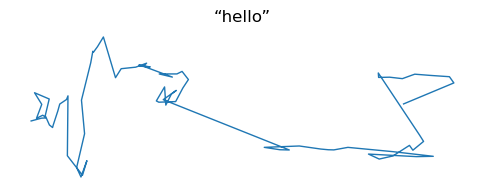

In [18]:
# %% [markdown]
# ## Define Generation Function

# %%
import numpy as np
import torch
import matplotlib.pyplot as plt

def generate_handwriting(model, text, char2idx, device, max_steps=300):
    model.eval()
    n_mix = model.dec.n_mix

    # 1. Tokenize
    seq  = ['<s>'] + list(text) + ['</s>']
    idxs = [char2idx.get(c, char2idx['<unk>']) for c in seq]
    T    = torch.tensor(idxs, device=device).unsqueeze(0)
    tL   = torch.tensor([len(idxs)], device=device)

    # 2. Initial stroke input
    prev    = torch.tensor([[0., 0., 1.]], device=device, dtype=torch.float32).unsqueeze(0)
    strokes = [prev.view(-1).cpu().numpy()]

    h = c = None
    enc = model.enc(T, tL)

    # 3. Autoregressive sampling
    for _ in range(max_steps):
        if h is None:
            nl, _, hs = model.dec.lstm.num_layers, 1, model.dec.lstm.hidden_size
            h = torch.zeros(nl, 1, hs, device=device)
            c = torch.zeros_like(h)

        ctx, _      = model.dec.attn(h[-1], enc)
        inp         = prev.view(1, 3)
        x_in        = torch.cat([inp, ctx], dim=1).unsqueeze(1)
        out, (h, c) = model.dec.lstm(x_in, (h, c))
        p           = model.dec.fc(out.squeeze(1)).squeeze(0)

        # sample mixture component
        pi_logits = p[:n_mix]
        pi_probs  = torch.softmax(pi_logits, dim=0).detach().cpu().numpy()
        comp      = np.random.choice(n_mix, p=pi_probs)

        # means & stds
        mu_x   = p[n_mix + comp].item()
        mu_y   = p[2*n_mix + comp].item()
        log_sx = p[3*n_mix + comp].item()
        log_sy = p[4*n_mix + comp].item()
        sx, sy = np.exp(log_sx), np.exp(log_sy)

        # sample deltas
        dx = mu_x + sx * np.random.randn()
        dy = mu_y + sy * np.random.randn()

        # sample pen-up
        pen_prob = torch.sigmoid(p[-1]).item()
        pen_up   = float(torch.bernoulli(torch.tensor(pen_prob)))

        prev = torch.tensor([[dx, dy, pen_up]], device=device, dtype=torch.float32).unsqueeze(0)
        strokes.append(prev.view(-1).cpu().numpy())

        if pen_up == 1.0 and len(strokes) > 60:
            break

    # 4. Render
    pts = np.cumsum(np.array(strokes), axis=0)
    plt.figure(figsize=(6,2))
    plt.plot(pts[:,0], -pts[:,1], linewidth=1)
    plt.axis('off')
    plt.title(f"“{text}”")
    plt.show()

# %% [markdown]
# ## Generate Handwriting

# %%
# Load best model if needed
model.load_state_dict(torch.load(os.path.join('models/', "best.pth"), map_location=DEVICE))
model.to(DEVICE)

user_text = input("Enter text to generate handwriting: ")
generate_handwriting(model, user_text, char2idx, DEVICE)
